In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from read_dataset import ImageDataset
from model import ResNet_18

BATCH_SIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# LOAD DATASET
dataset = ImageDataset(data_folder='dataset/images', label_file='dataset/images/image_data.json',
                       transform=transforms.Compose([transforms.ToTensor()]))
trainset, testset = torch.utils.data.random_split(dataset, [4000, 1000])
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

m = torch.load('models/model2moretrained.pt').to(DEVICE)

/tmp/ipykernel_59137/2687846127.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m = torch.load('models/model2moretrained.pt').to(DEVICE)


In [4]:
data, labels = next(iter(test_loader))

In [5]:
pred = torch.argmax(m(data.to(DEVICE)), dim=1)


torch.Size([64, 2])
torch.Size([64, 2])


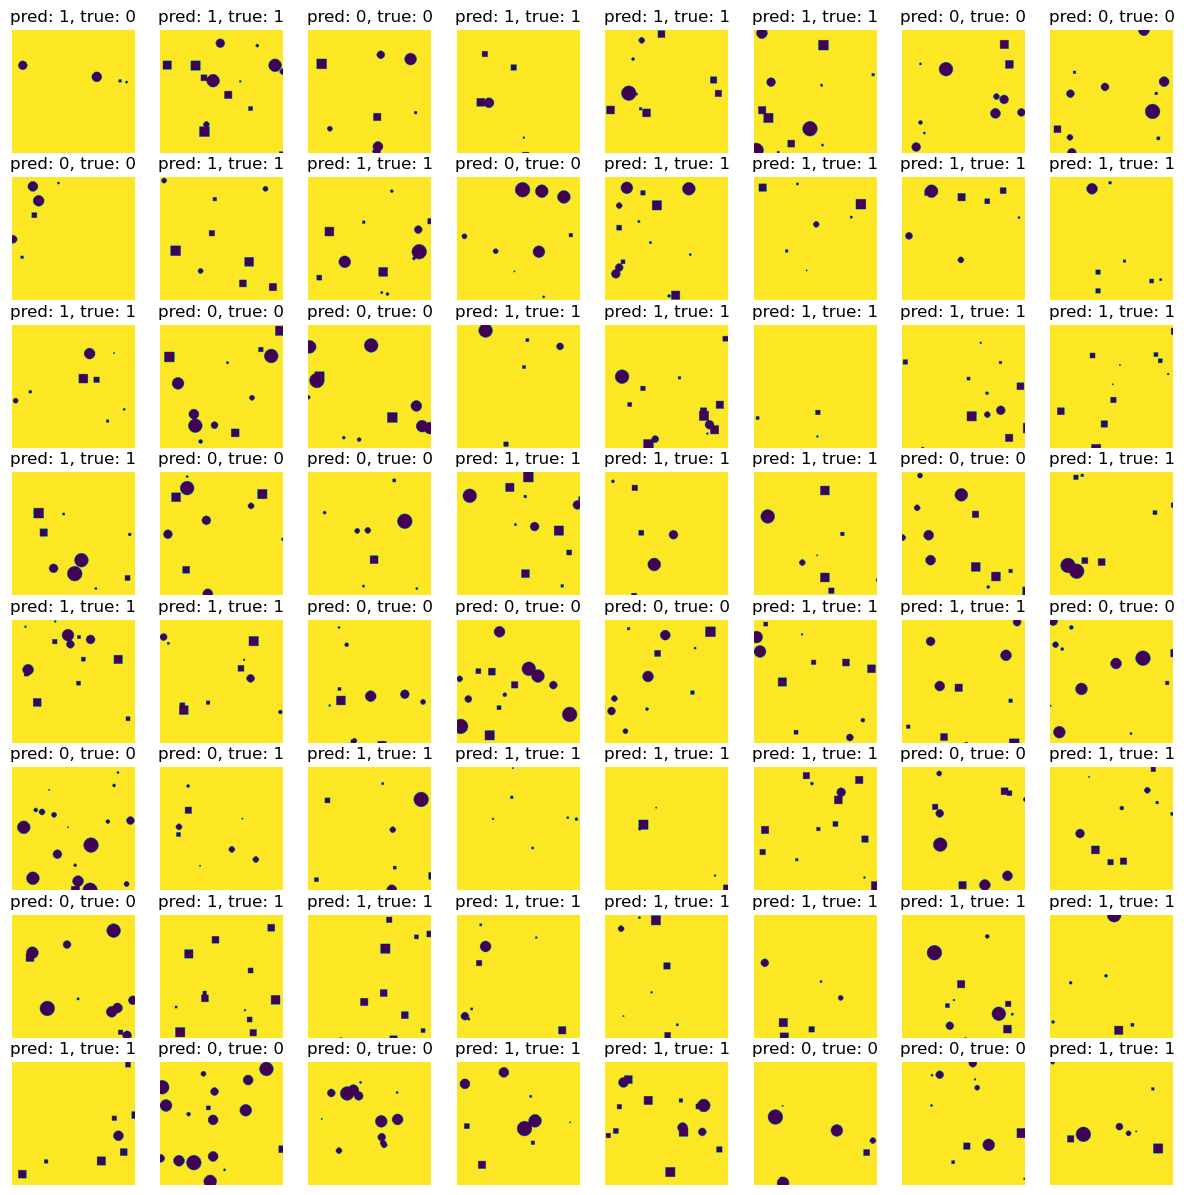

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(8, 8, figsize=(15, 15))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.imshow(data[i].permute(1, 2, 0))
    ax.set_title(f'pred: {pred[i]}, true: {labels[i]}')
    ax.axis('off')

In [3]:
from stitcher import StitchedModel
from model import ResNet_18
from read_dataset import ImageDataset, CountDataset
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

m = torch.load('dataset/density_experiment/model_10.pt').to(DEVICE)
stitch = StitchedModel(m).to(DEVICE)

dataset = CountDataset(data_folder='dataset/counting_experiment/',
                       label_file='dataset/counting_experiment/image_data.json')

EPOCHS = 5
BATCH_SIZE = 64
LEARNING_RATE = 0.0003

trainset, testset = torch.utils.data.random_split(dataset, [4000, 1000])
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

for param in stitch.parameters():
    param.requires_grad = False
for param in stitch.avgpool.parameters():
    param.requires_grad = True
for param in stitch.fc1.parameters():
    param.requires_grad = True
for param in stitch.fc2.parameters():
    param.requires_grad = True

optimizer = optim.Adam(stitch.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    for i, (image, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        image, labels = image.to(DEVICE), labels.to(DEVICE)
        labels = labels.sum(dim=1).to(torch.float32)
        pred = stitch(image).squeeze()
        loss = F.mse_loss(pred, labels)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss}')

/tmp/ipykernel_172205/1699684797.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m = torch.load('dataset/density_experiment/model_10.pt').to(DEVICE)


Epoch: 0, Batch: 0, Loss: 1088.82177734375
Epoch: 0, Batch: 10, Loss: 1142.0911865234375
Epoch: 0, Batch: 20, Loss: 1062.9637451171875
Epoch: 0, Batch: 30, Loss: 1087.197265625
Epoch: 0, Batch: 40, Loss: 1178.6495361328125
Epoch: 0, Batch: 50, Loss: 948.051025390625
Epoch: 0, Batch: 60, Loss: 931.1332397460938
Epoch: 1, Batch: 0, Loss: 983.8692016601562
Epoch: 1, Batch: 10, Loss: 1165.725341796875
Epoch: 1, Batch: 20, Loss: 1155.52001953125
Epoch: 1, Batch: 30, Loss: 915.73876953125
Epoch: 1, Batch: 40, Loss: 888.0955200195312
Epoch: 1, Batch: 50, Loss: 835.5333862304688
Epoch: 1, Batch: 60, Loss: 920.578857421875
Epoch: 2, Batch: 0, Loss: 1066.4384765625
Epoch: 2, Batch: 10, Loss: 1092.235107421875
Epoch: 2, Batch: 20, Loss: 886.8768310546875
Epoch: 2, Batch: 30, Loss: 1029.6416015625
Epoch: 2, Batch: 40, Loss: 1081.32861328125
Epoch: 2, Batch: 50, Loss: 1072.1875
Epoch: 2, Batch: 60, Loss: 1046.9847412109375
Epoch: 3, Batch: 0, Loss: 1079.4697265625
Epoch: 3, Batch: 10, Loss: 1034.65

In [2]:
from metrics import test_acc

print(test_acc(m, test_loader, DEVICE))

0.989
